<a href="https://colab.research.google.com/github/russmendez/DS_Thinkful_Mendez/blob/master/COVID_global_case_numbers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [ ]:
import requests
from bs4 import BeautifulSoup
import lxml.html as lh
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from pandas import DataFrame
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split, cross_val_score

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression

from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import KNeighborsRegressor

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor

from sklearn.dummy import DummyClassifier

from sklearn import preprocessing

from sklearn import metrics

from sklearn.datasets import make_classification
from sklearn.datasets import make_blobs

from mlxtend.plotting import plot_decision_regions
import math

from sklearn.preprocessing import StandardScaler

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, fbeta_score
from sklearn.metrics import roc_curve, precision_recall_curve, roc_auc_score
%matplotlib inline
import statsmodels.api as sm

from scipy.stats import bartlett
from scipy.stats import levene


In [ ]:
url = 'https://www.worldometers.info/coronavirus/'

#Create a handle, page, to handle the contents of the website
page = requests.get(url)
#Store the contents of the website under doc
doc = lh.fromstring(page.content)
#Parse data that are stored between <tr>..</tr> of HTML
tr_elements = doc.xpath('//tr')

In [ ]:
#Check the length of the first 12 rows to ensure all rows have the same amount of data
[len(T) for T in tr_elements[:12]]

[19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19]

In [ ]:
tr_elements = doc.xpath('//tr')
#Create empty list
col=[]
i=0
#For each row, store each first element (header) and an empty list
for t in tr_elements[0]:
    i+=1
    name=t.text_content()
    print(i,name)
    col.append((name,[]))

1 #
2 Country,Other
3 TotalCases
4 NewCases
5 TotalDeaths
6 NewDeaths
7 TotalRecovered
8 NewRecovered
9 ActiveCases
10 Serious,Critical
11 Tot Cases/1M pop
12 Deaths/1M pop
13 TotalTests
14 Tests/
1M pop

15 Population
16 Continent
17 1 Caseevery X ppl
18 1 Deathevery X ppl
19 1 Testevery X ppl


In [ ]:
#Since out first row is the header, data is stored on the second row onwards
for j in range(1,len(tr_elements)):
    #T is our j'th row
    T=tr_elements[j]
    
    #If row is not of size 19, the //tr data is not from our table 
    if len(T)!=19:
        break
    
    #i is the index of our column
    i=0
    
    #Iterate through each element of the row
    for t in T.iterchildren():
        data=t.text_content() 
        #Check if row is empty
        if i>0:
        #Convert any numerical value to integers
            try:
                data=int(data)
            except:
                pass
        #Append the data to the empty list of the i'th column
        col[i][1].append(data)
        #Increment i for the next column
        i+=1



In [ ]:
[len(C) for (title,C) in col]

[707,
 707,
 707,
 707,
 707,
 707,
 707,
 707,
 707,
 707,
 707,
 707,
 707,
 707,
 707,
 707,
 707,
 707,
 707]

In [ ]:
Dict={title:column for (title,column) in col}
master_df=pd.DataFrame(Dict)
df = master_df.copy()
#df = master_df[['Country,Other','Continent', 'TotalCases', 'NewCases', 'TotalDeaths',
       #'NewDeaths', 'TotalRecovered', 'NewRecovered', 'ActiveCases',
       #'Serious,Critical', 'TotalTests', 'Population']]
#today_df = master_df.iloc[0:235].copy()
#yesterday_df = master_df.iloc[235:470].copy()
#two_day_df = master_df.iloc[470:707]

In [ ]:
#print(len(today_df))
#print(len(yesterday_df))
#print(len(two_day_df))

In [ ]:
#SOMETHING TO WORK ON ---- understand how the Total chart's layout. How to handle the the fact that every entry is there 3 times and it throws off the actual total
country_list = df['Country,Other'].unique()
for i in country_list:
  if len(df[df['Country,Other'] == i]) == 3:
    pass
  else:
    print(f'{i}')

Total:
Country,Other


In [ ]:
#Remove '+' from columns where it exsists.
df['NewCases'] = df['NewCases'].str.replace('+','')
df['NewDeaths'] = df['NewDeaths'].str.replace('+','')
df['NewRecovered'] = df['NewRecovered'].str.replace('+','')
#Remove '\n' Countr,Other
df['Country,Other'] = df['Country,Other'].map(lambda x: x.lstrip('\n').rstrip('\n'))
#Remove extra rows 
df = df[df['NewCases'] != 'NewCases']
df = df[df['Country,Other'] != '']
df = df[df['Country,Other'] != 'Total:']

# Data Cleaning

In [ ]:
#Get the mean for NewCases with numeric values. 
#This removes '' and Nas. This code results in using 206 values to estimate the mean for the remmaining 499
NC_df = pd.DataFrame(df['NewCases'])
NC_df = NC_df.dropna()
NC_df = NC_df[NC_df['NewCases'] != '']
NC_df['NewCases'] = NC_df['NewCases'].str.replace(',','').astype(float)
x = NC_df['NewCases'].mean()

df['NewCases'] = df['NewCases'].str.replace(',','')
df['NewCases'] = df['NewCases'].replace('',x).astype(float)
df['NewCases'] = df['NewCases'].fillna(x)
#The .mean() function will be used to ensure all values in the column are floats
df.NewCases.mean()

25923.047337278334

In [ ]:
#Get the mean for NewDeaths with numeric values.
#This removes '' and Nas. This code results in using 31 values to estimate the mean for the remmaining 674
ND_df = pd.DataFrame(df['NewDeaths'])
ND_df = ND_df.dropna()
ND_df = ND_df[ND_df['NewDeaths'] != '']
ND_df['NewDeaths'] = ND_df['NewDeaths'].str.replace(',','').astype(float)
x = ND_df['NewDeaths'].mean()

df['NewDeaths'] = df['NewDeaths'].str.replace(',','')
df['NewDeaths'] = df['NewDeaths'].replace('',x).astype(float)
df['NewDeaths'] = df['NewDeaths'].fillna(x)

df.NewDeaths.mean()

3342.4285714285966

In [ ]:
#Get the mean for NewRecovered with numeric values.
#This removes '' and Nas and 'N/A. This code results in using 146 values to estimate the mean for the remmaining 560
NR_df = pd.DataFrame(df['NewRecovered'])
NR_df = NR_df.dropna()
NR_df = NR_df[NR_df['NewRecovered'] != '']
NR_df = NR_df[NR_df['NewRecovered'] != 'N/A']
NR_df['NewRecovered'] = NR_df['NewRecovered'].str.replace(',','').astype(float)
x = NR_df['NewRecovered'].mean()

df['NewRecovered'] = df['NewRecovered'].str.replace(',','')
df['NewRecovered'] = df['NewRecovered'].replace(['', 'N/A'],x).astype(float) 
df['NewRecovered'] = df['NewRecovered'].fillna(x)

df.NewRecovered.mean()

24449.30434782615

In [ ]:
#Important discovery. The df is in lxml.etree._ElementUnicodeResult format. 
#A quick fix for numerical data to make the data usable is to add a '.0' then convert to float by removing ','
#NOTE TO SELF - a for loop may be able to fix all the columns initially and save me from having to use the above code. work on this is time allows.
df['TotalCases'] = df['TotalCases'].apply(lambda x:f'{x}.0')
df['TotalCases'] = df['TotalCases'].str.replace(',', '').astype(float)
df['TotalCases'].mean()

711137.2876106194

In [ ]:
df['TotalDeaths'] = df['TotalDeaths'].astype(str).apply(lambda x: f'{x}.0')
df['TotalDeaths'] = df['TotalDeaths'].str.replace(',', '')
df['TotalDeaths'] = df['TotalDeaths'].str.replace(' ', '')
df['TotalDeaths'] = df['TotalDeaths'].astype(float)
df['TotalDeaths'].mean()

17342.438053097347

In [ ]:
#TotalRecovered
#First, get the mean of the vnumeric values
TR_df = pd.DataFrame(df['TotalRecovered'])
TR_df = TR_df[TR_df['TotalRecovered'] != 'N/A']
TR_df['TotalRecovered'] = TR_df['TotalRecovered'].astype(str).apply(lambda x: f'{x}.0')
TR_df['TotalRecovered'] = TR_df['TotalRecovered'].str.replace(',', '')
TR_df['TotalRecovered'] = TR_df['TotalRecovered'].str.replace(' ', '')
TR_df['TotalRecovered'] = TR_df['TotalRecovered'].astype(float)
x = round(TR_df['TotalRecovered'].mean())
print(x)
#Convert numbers to in and replace the N/A with the mean
df['TotalRecovered'] = df[df['TotalRecovered'] != 'N/A']
df['TotalRecovered'] = df['TotalRecovered'].fillna(x)
df['TotalRecovered'] = df['TotalRecovered'].astype(str).apply(lambda x: f'{x}.0')
df['TotalRecovered'] = df['TotalRecovered'].str.replace(',', '')
df['TotalRecovered'] = df['TotalRecovered'].str.replace(' ', '')

df['TotalRecovered'] = df['TotalRecovered'].astype(float)

503854


In [ ]:
#ActiveCases
#Remove 'N/A' and get mean
AC_df = pd.DataFrame(df['ActiveCases'])
AC_df = AC_df[AC_df['ActiveCases'] != 'N/A']
AC_df['ActiveCases'] = AC_df['ActiveCases'].apply(lambda x:f'{x}.0')
AC_df['ActiveCases'] = AC_df['ActiveCases'].str.replace(',', '').astype(float)
x = round(AC_df['ActiveCases'].mean())
#convert to strine and repalce 'N/A' with mean
df = df[df['ActiveCases'] != 'N/A']
df['ActiveCases'] = df['ActiveCases'].fillna(x)
df['ActiveCases'] = df['ActiveCases'].apply(lambda x:f'{x}.0')
df['ActiveCases'] = df['ActiveCases'].str.replace(',', '').astype(float)

In [ ]:
#Serious,Critical
df['Serious,Critical'] = df['Serious,Critical'].apply(lambda x:f'{x}.0')
df['Serious,Critical'] = df['Serious,Critical'].str.replace(',', '').astype(float)
df['Serious,Critical'].mean()

1394.566066066066

In [ ]:
#Population
df['Population'] = df['Population'].astype(str).apply(lambda x: f'{x}.0')
df['Population'] = df['Population'].str.replace(',', '')
df['Population'] = df['Population'].str.replace(' ', '')
df['Population'] = df['Population'].astype(float)

In [ ]:
#TotalTests
df['TotalTests'] = df['TotalTests'].apply(lambda x:f'{x}.0')
df['TotalTests'] = df['TotalTests'].str.replace(',', '').astype(float)
df['TotalTests'].mean()

3768583.490990991

In [ ]:
df['Continent'] = df['Continent'].astype(str)

In [ ]:
clean_df = df[['Country,Other','Continent', 'TotalCases', 'NewCases', 'TotalDeaths',
       'NewDeaths', 'TotalRecovered', 'NewRecovered', 'ActiveCases',
       'Serious,Critical', 'TotalTests', 'Population']]

# Functions

In [ ]:
#probs = lr.predict_proba(X_test)[:, 1]
#pres, rec, thresholds = precision_recall_curve(y_test, lr_predictions)
#Change model abbreviation
def pr_roc(var):

  plt.figure()
  fig = plt.figure(figsize= (18,6))

  plt.subplot(1,3,1)

  fpr, tpr, thresholds = roc_curve(y_test, probs)
  #fig = plt.figure(figsize = (6, 6))
  plt.plot([0, 1], [0, 1], 'k--')
  plt.plot(fpr, tpr)
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('ROC curve for Logistic Regression Model')
  #plt.show()

  plt.subplot(1,3,2)

  #fig = plt.figure(figsize = (6, 6))
  plt.plot(rec, pres)
  plt.xlabel('Recall')
  plt.ylabel('Precision')
  plt.title('Precision-Recall Curve')
  #plt.show()

  plt.subplot(1,3,3)
  #fig = plt.figure(figsize = (6, 6))
  plt.plot([0, 1], [0, 1], 'k--')
  plt.plot(fpr, tpr)
  plt.fill(fpr, tpr, 'grey', alpha=0.3)
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('ROC curve for Logistic Regression Model')
  #plt.show()
  auc = roc_auc_score(y_test, probs)
  print('Area under the ROC curve: {:.3f}'.format(auc))

# Models

## Linear Classification. 
It is important to note that these models are classifiers and they expect the target variable to be categorical. Using df.astype(int) will allow the code to run but it is questionable if is best. A better solution is to make the target variable into a category. In this case it will be a dichotomy, greater than or less than the mean of NewCases

In [ ]:
x =clean_df['NewCases'].mean()
classification_df = pd.concat([clean_df, pd.get_dummies(clean_df['Country,Other'])], axis=1)
classification_df = pd.concat([classification_df, pd.get_dummies(clean_df['Continent'])], axis=1)
#do no drop_first because the categories are greater than 2. drop first is best for dichotomies, i.e. gender. 
#you don't need male & female beacuse male=1 is male and male=0 is female. 
classification_df.drop(['Country,Other', 'Continent'], axis=1, inplace=True)
#encode the target variable
classification_df.loc[classification_df['NewCases'] < x, 'NewCases'] = 0
classification_df.loc[classification_df['NewCases'] > x, 'NewCases'] = 1
classification_df.head()
X = classification_df.drop(['NewCases'], axis=1)
y = classification_df['NewCases']
 

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=5)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(532, 239)
(532,)
(134, 239)
(134,)


In [ ]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 532 entries, 300 to 211
Columns: 239 entries, TotalCases to South America
dtypes: float64(9), uint8(230)
memory usage: 161.1 KB


### LogisticRegression

In [ ]:
lr = LogisticRegression(solver='lbfgs', max_iter=1000)
results =lr.fit(X_train, y_train)

lr_score = lr.score(X_test, y_test)
lr_predictions = lr.predict(X_test)

train_score = lr.score(X_train, y_train)
test_score = lr.score(X_test, y_test)

print('Score on training data: ', train_score)
print('Score on test data: ', test_score)
print(confusion_matrix(y_test, lr_predictions))
print(classification_report(y_test, lr_predictions))
#To favor precision, a value of  𝛽<1  is used, and to favor recall, a value of  𝛽>1  is used
fbeta_precision = fbeta_score(y_test, lr_predictions, 0.5)
fbeta_recall = fbeta_score(y_test, lr_predictions, 2)
print('Fbeta score favoring precision: {:.2f}'.format(fbeta_precision))
print('FBeta score favoring recall: {:.2f}'.format(fbeta_recall))

Score on training data:  0.9924812030075187
Score on test data:  0.9850746268656716
[[131   1]
 [  1   1]]
              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99       132
         1.0       0.50      0.50      0.50         2

    accuracy                           0.99       134
   macro avg       0.75      0.75      0.75       134
weighted avg       0.99      0.99      0.99       134

Fbeta score favoring precision: 0.50
FBeta score favoring recall: 0.50


Area under the ROC curve: 0.996


<Figure size 432x288 with 0 Axes>

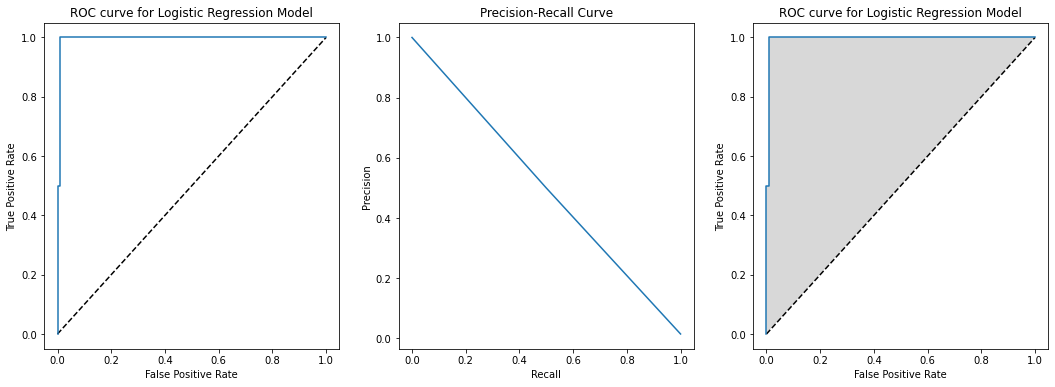

In [ ]:
probs = lr.predict_proba(X_test)[:, 1]
pres, rec, thresholds = precision_recall_curve(y_test, lr_predictions)
pr_roc(lr)

In [ ]:
#Check the regularized version agains the non-regularized
lr_regularized = LogisticRegression(solver='lbfgs', penalty='l2', max_iter=10000, random_state=2)
lr_regularized.fit(X_train, y_train)

test_score = lr_regularized.score(X_test, y_test)
train_score = lr_regularized.score(X_train, y_train)

print('Score on training data: ', train_score)
print('Score on test data: ', test_score)

Score on training data:  0.9924812030075187
Score on test data:  0.9850746268656716


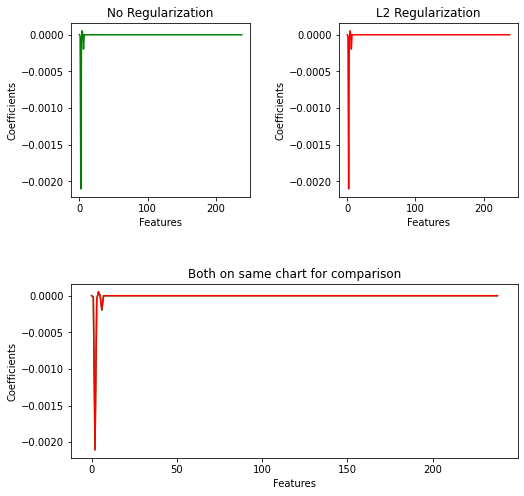

In [ ]:
fig = plt.figure(figsize=(8, 8))
grid = plt.GridSpec(2, 2, hspace=0.5, wspace=0.5)


x = np.arange(0, len(lr.coef_[0]),1)
y = lr.coef_[0]
ax1 = fig.add_subplot(grid[0, 0])
ax1.plot(x, y, '-g')
ax1.set(xlabel='Features', ylabel='Coefficients')
ax1.set_title('No Regularization')

y_reg = lr_regularized.coef_[0]
ax2 = fig.add_subplot(grid[0, 1])
ax2.plot(x, y_reg, '-r')
ax2.set(xlabel='Features', ylabel='Coefficients')
ax2.set_title('L2 Regularization')

ax3 = fig.add_subplot(grid[1, 0:])
ax3.plot(x, y, '-g')
ax3.plot(x, y_reg, '-r')

ax3.set(xlabel='Features', ylabel='Coefficients')
ax3.set_title('Both on same chart for comparison')
plt.show()

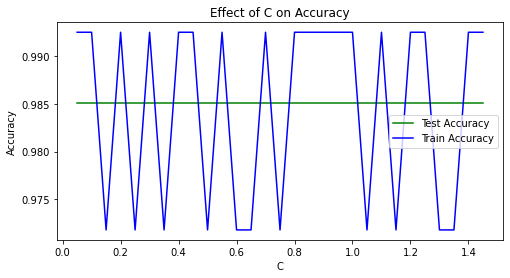

In [ ]:
c_vals = np.arange(0.05, 1.5, 0.05)
test_accuracy = []
train_accuracy = []

for c in c_vals:
  lr = LogisticRegression(solver='lbfgs', penalty='l2', C=c, max_iter=10000, random_state=2)
  lr.fit(X_train, y_train)
  test_accuracy.append(lr.score(X_test, y_test))
  train_accuracy.append(lr.score(X_train, y_train))

fig = plt.figure(figsize=(8, 4))
ax1 = fig.add_subplot(1, 1, 1)
ax1.plot(c_vals, test_accuracy, '-g', label='Test Accuracy')
ax1.plot(c_vals, train_accuracy, '-b', label='Train Accuracy')
ax1.set(xlabel='C', ylabel='Accuracy')
ax1.set_title('Effect of C on Accuracy')
ax1.legend()
plt.show()

In [ ]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(clean_df)
data_df_scaled = pd.DataFrame(scaled_data, columns=breast_cancer.feature_names)
data_df_scaled.describe()

ValueError: ignored

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data_df_scaled, breast_cancer.target, random_state=2)
lr = LogisticRegression(solver='lbfgs', max_iter=10000, penalty='l2', C=0.6, random_state=2)
lr.fit(X_train, y_train)

test_score = lr.score(X_test, y_test)
train_score = lr.score(X_train, y_train)

print('Score on training data: ', train_score)
print('Score on test data: ', test_score)

NameError: ignored

### LinearSVM

In [ ]:
svm = LinearSVC(max_iter=10000)
svm.fit(X_train, y_train)
svm_score = svm.score(X_test, y_test)
svm_predictions = svm.predict(X_test)

train_score = svm.score(X_train, y_train)
test_score = svm.score(X_test, y_test)

print('Score on training data: ', train_score)
print('Score on test data: ', test_score)
print(confusion_matrix(y_test, svm_predictions))
print(classification_report(y_test, svm_predictions))

fbeta_precision = fbeta_score(y_test, svm_predictions, 0.5)
fbeta_recall = fbeta_score(y_test, svm_predictions, 2)
print('Fbeta score favoring precision: {:.2f}'.format(fbeta_precision))
print('FBeta score favoring recall: {:.2f}'.format(fbeta_recall))

Score on training data:  0.9755639097744361
Score on test data:  0.9925373134328358
[[132   0]
 [  1   1]]
              precision    recall  f1-score   support

         0.0       0.99      1.00      1.00       132
         1.0       1.00      0.50      0.67         2

    accuracy                           0.99       134
   macro avg       1.00      0.75      0.83       134
weighted avg       0.99      0.99      0.99       134

Fbeta score favoring precision: 0.83
FBeta score favoring recall: 0.56


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [ ]:
probs = svm.predict_proba(X_test)[:, 1]
pres, rec, thresholds = precision_recall_curve(y_test, svm_predictions)
pr_roc(svm)

AttributeError: ignored

### KNeighborClassifier

In [ ]:
knn = KNeighborsClassifier(n_neighbors=7)

# Then  fit the model
knn.fit(X_train, y_train)

# How well did we do
knn_7_score = knn.score(X_test, y_test)
knn_7_predictions = knn.predict(X_test)

train_score = knn.score(X_train, y_train)
test_score = knn.score(X_test, y_test)

print('Score on training data: ', train_score)
print('Score on test data: ', test_score)
print(confusion_matrix(y_test, knn_7_predictions))
print(classification_report(y_test, knn_7_predictions))

fbeta_precision = fbeta_score(y_test, knn_7_predictions, 0.5)
fbeta_recall = fbeta_score(y_test, knn_7_predictions, 2)
print('Fbeta score favoring precision: {:.2f}'.format(fbeta_precision))
print('FBeta score favoring recall: {:.2f}'.format(fbeta_recall))

Score on training data:  0.981203007518797
Score on test data:  0.9925373134328358
[[132   0]
 [  1   1]]
              precision    recall  f1-score   support

         0.0       0.99      1.00      1.00       132
         1.0       1.00      0.50      0.67         2

    accuracy                           0.99       134
   macro avg       1.00      0.75      0.83       134
weighted avg       0.99      0.99      0.99       134

Fbeta score favoring precision: 0.83
FBeta score favoring recall: 0.56


Area under the ROC curve: 0.992


<Figure size 432x288 with 0 Axes>

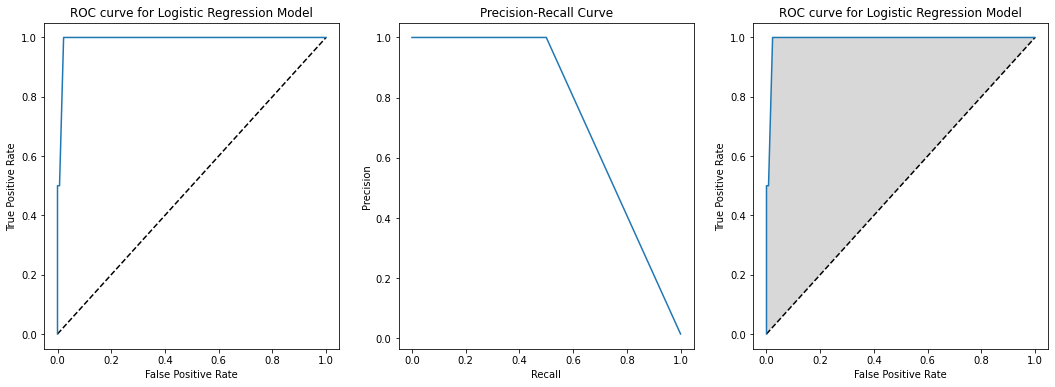

In [ ]:
probs = knn.predict_proba(X_test)[:, 1]
pres, rec, thresholds = precision_recall_curve(y_test, knn_7_predictions)
pr_roc(knn)

In [ ]:
knn = KNeighborsClassifier(n_neighbors=5)

# Then  fit the model
knn.fit(X_train, y_train)

# How well did we do
knn_5_score = knn.score(X_test, y_test)
knn_5_predictions = knn.predict(X_test)

train_score = knn.score(X_train, y_train)
test_score = knn.score(X_test, y_test)

print('Score on training data: ', train_score)
print('Score on test data: ', test_score)
print(confusion_matrix(y_test, knn_5_predictions))
print(classification_report(y_test, knn_5_predictions))

fbeta_precision = fbeta_score(y_test, knn_5_predictions, 0.5)
fbeta_recall = fbeta_score(y_test, knn_5_predictions, 2)
print('Fbeta score favoring precision: {:.2f}'.format(fbeta_precision))
print('FBeta score favoring recall: {:.2f}'.format(fbeta_recall))

Score on training data:  0.9830827067669173
Score on test data:  0.9925373134328358
[[132   0]
 [  1   1]]
              precision    recall  f1-score   support

         0.0       0.99      1.00      1.00       132
         1.0       1.00      0.50      0.67         2

    accuracy                           0.99       134
   macro avg       1.00      0.75      0.83       134
weighted avg       0.99      0.99      0.99       134

Fbeta score favoring precision: 0.83
FBeta score favoring recall: 0.56


Area under the ROC curve: 0.996


<Figure size 432x288 with 0 Axes>

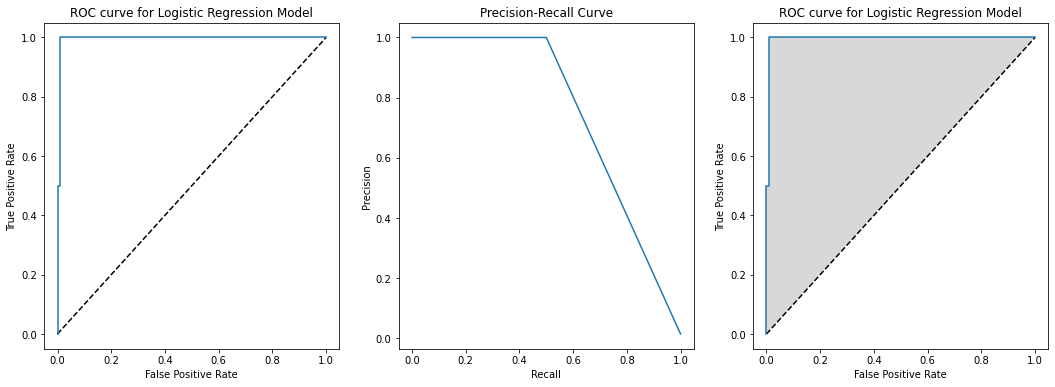

In [ ]:
probs = knn.predict_proba(X_test)[:, 1]
pres, rec, thresholds = precision_recall_curve(y_test, knn_7_predictions)
pr_roc(knn)

### Decision Tree Classifier

In [ ]:
dt = DecisionTreeClassifier()

dt.fit(X_train,y_train)

dt_score = dt.score(X_test, y_test)
dt_predictions = dt.predict(X_test)

train_score = dt.score(X_train, y_train)
test_score = dt.score(X_test, y_test)

print('Score on training data: ', train_score)
print('Score on test data: ', test_score)
print(confusion_matrix(y_test, dt_predictions))
print(classification_report(y_test, dt_predictions))

fbeta_precision = fbeta_score(y_test, dt_predictions, 0.5)
fbeta_recall = fbeta_score(y_test, dt_predictions, 2)
print('Fbeta score favoring precision: {:.2f}'.format(fbeta_precision))
print('FBeta score favoring recall: {:.2f}'.format(fbeta_recall))

Score on training data:  1.0
Score on test data:  0.9925373134328358
[[132   0]
 [  1   1]]
              precision    recall  f1-score   support

         0.0       0.99      1.00      1.00       132
         1.0       1.00      0.50      0.67         2

    accuracy                           0.99       134
   macro avg       1.00      0.75      0.83       134
weighted avg       0.99      0.99      0.99       134

Fbeta score favoring precision: 0.83
FBeta score favoring recall: 0.56


Area under the ROC curve: 0.750


<Figure size 432x288 with 0 Axes>

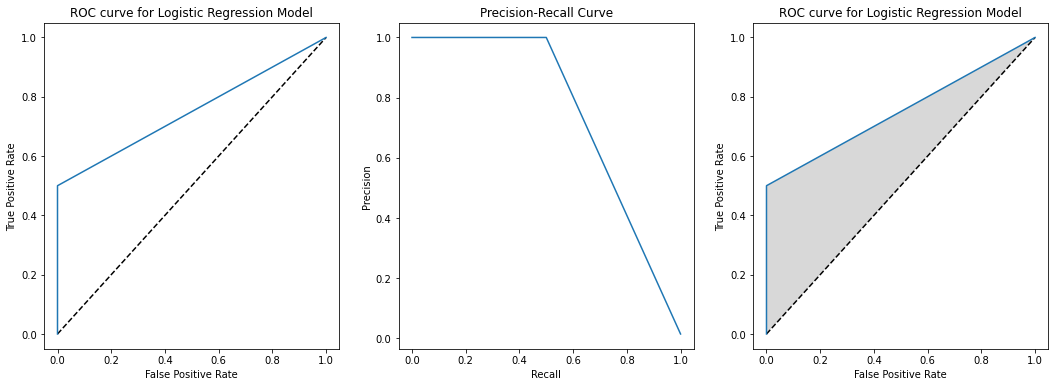

In [ ]:
probs = dt.predict_proba(X_test)[:, 1]
pres, rec, thresholds = precision_recall_curve(y_test, dt_predictions)
pr_roc(dt)

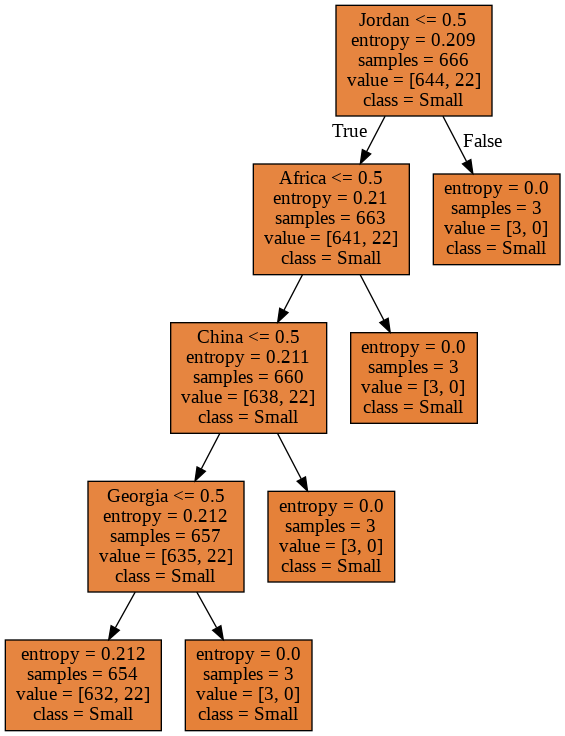

In [ ]:
from sklearn import tree
from IPython.display import Image

# Packages for rendering our tree.
import pydotplus
import graphviz

# Initialize and train our tree.
decision_tree = DecisionTreeClassifier(
    criterion='entropy',
    max_features=1,
    max_depth=4,
    random_state = 1337
)
decision_tree.fit(X,y)

# Render our tree.
dot_data = tree.export_graphviz(
    decision_tree, out_file=None,
    feature_names=X.columns,
    class_names=['Small', 'Large'],
    filled=True
)
graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())

### RandomForestClassifer

In [ ]:
rf = RandomForestClassifier(n_estimators = 22, random_state = 40)

rf.fit(X_train,y_train)

rf_score = rf.score(X_test, y_test)
rf_predictions = rf.predict(X_test)

train_score = rf.score(X_train, y_train)
test_score = rf.score(X_test, y_test)

print('Score on training data: ', train_score)
print('Score on test data: ', test_score)
print(confusion_matrix(y_test, rf_predictions))
print(classification_report(y_test, rf_predictions))

fbeta_precision = fbeta_score(y_test, rf_predictions, 0.5)
fbeta_recall = fbeta_score(y_test, rf_predictions, 2)
print('Fbeta score favoring precision: {:.2f}'.format(fbeta_precision))
print('FBeta score favoring recall: {:.2f}'.format(fbeta_recall))

Score on training data:  1.0
Score on test data:  0.9850746268656716
[[131   1]
 [  1   1]]
              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99       132
         1.0       0.50      0.50      0.50         2

    accuracy                           0.99       134
   macro avg       0.75      0.75      0.75       134
weighted avg       0.99      0.99      0.99       134

Fbeta score favoring precision: 0.50
FBeta score favoring recall: 0.50


Area under the ROC curve: 0.996


<Figure size 432x288 with 0 Axes>

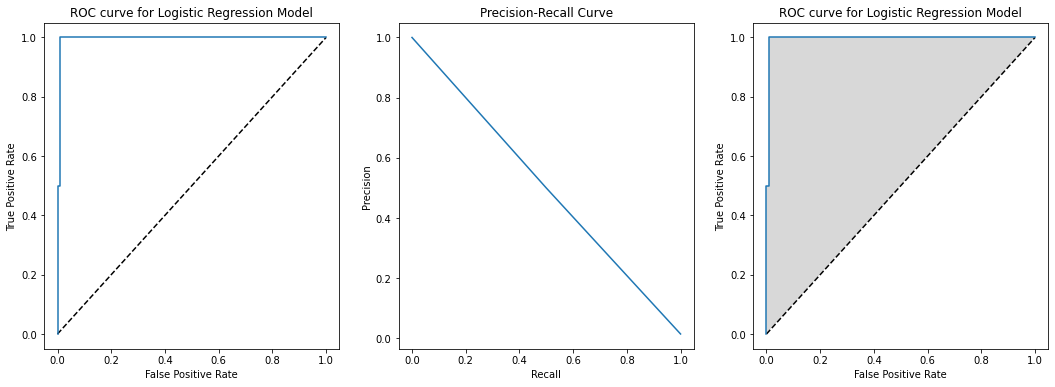

In [ ]:
probs = rf.predict_proba(X_test)[:, 1]
pres, rec, thresholds = precision_recall_curve(y_test, rf_predictions)
pr_roc(rf)

### Misc

In [ ]:
predictions_dictionary = {'Logistic Regression' : lr_predictions, 'KNN_7' : knn_7_predictions, 
                          'KNN_5': knn_5_predictions, 'SVM' : svm_predictions, 'Decision Tree' : dt_predictions, 
                          'Random Forest' : rf_predictions, 'Actual': y_test}

predictions_df = pd.DataFrame(predictions_dictionary)
predictions_df
#This may not be a useful tool with this target variable

,Logistic Regression,KNN_7,KNN_5,SVM,Decision Tree,Random Forest,Actual
516,0.0,0.0,0.0,0.0,0.0,0.0,0.0
355,0.0,0.0,0.0,0.0,0.0,0.0,0.0
89,0.0,0.0,0.0,0.0,0.0,0.0,0.0
501,0.0,0.0,0.0,0.0,0.0,0.0,0.0
247,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...
404,0.0,0.0,0.0,0.0,0.0,0.0,0.0
569,0.0,0.0,0.0,0.0,0.0,0.0,0.0
378,0.0,0.0,0.0,0.0,0.0,0.0,0.0
55,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Visualization

/usr/local/lib/python3.6/dist-packages/mlxtend/plotting/decision_regions.py:244: MatplotlibDeprecationWarning: Passing unsupported keyword arguments to axis() will raise a TypeError in 3.3.
  ax.axis(xmin=xx.min(), xmax=xx.max(), y_min=yy.min(), y_max=yy.max())


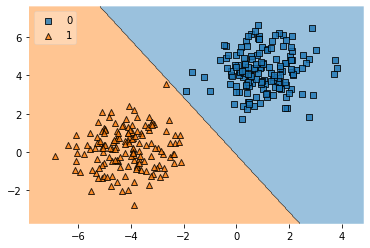

In [ ]:
X, y = make_blobs(n_samples=300, centers=2, n_features=2, cluster_std=1.0, random_state=3)

lr = LogisticRegression(solver='lbfgs', random_state=5)
lr.fit(X, y)

plot_decision_regions(X, y, clf=lr, legend=2)
plt.show()

#What is this showing me?

/usr/local/lib/python3.6/dist-packages/mlxtend/plotting/decision_regions.py:244: MatplotlibDeprecationWarning: Passing unsupported keyword arguments to axis() will raise a TypeError in 3.3.
  ax.axis(xmin=xx.min(), xmax=xx.max(), y_min=yy.min(), y_max=yy.max())


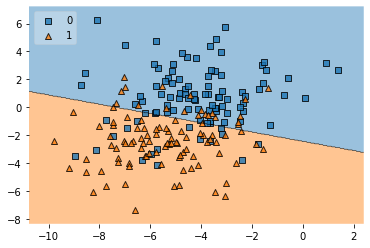

In [ ]:
X, y = make_blobs(n_samples=200, centers=2, n_features=2, cluster_std=2.0, random_state = 225)

lr = LogisticRegression(solver='lbfgs', random_state=5)
lr.fit(X, y)

plot_decision_regions(X, y, clf=lr, legend=2)
plt.show()

## Multiclass Clasification 
This can be done in a variety of ways for the target data. 

### LogisticRegression

In [ ]:
encoded_df = pd.concat([clean_df, pd.get_dummies(clean_df['Country,Other'])], axis=1)
encoded_df = pd.concat([encoded_df, pd.get_dummies(clean_df['Continent'])], axis=1)
encoded_df.drop(['Country,Other', 'Continent'], axis=1, inplace=True)
encoded_df.head()
X = encoded_df.drop(['NewCases'], axis=1)
y = encoded_df['NewCases'].astype(int)


X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=5)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(532, 239)
(532,)
(134, 239)
(134,)


In [ ]:
mc_lr = LogisticRegression(solver='lbfgs', max_iter=1000)
mc_lr.fit(X_train, y_train)

mc_lr_score = mc_lr.score(X_test, y_test)
mc_lr_predictions = mc_lr.predict(X_test)

train_score = mc_lr.score(X_train, y_train)
test_score = mc_lr.score(X_test, y_test)

print('Score on training data: ', train_score)
print('Score on test data: ', test_score)
print(confusion_matrix(y_test, mc_lr_predictions))
print(classification_report(y_test, mc_lr_predictions))
#To favor precision, a value of  𝛽<1  is used, and to favor recall, a value of  𝛽>1  is used
fbeta_precision = fbeta_score(y_test, mc_lr_predictions, 0.5)
fbeta_recall = fbeta_score(y_test, mc_lr_predictions, 2)
print('Fbeta score favoring precision: {:.2f}'.format(fbeta_precision))
print('FBeta score favoring recall: {:.2f}'.format(fbeta_recall))

Score on training data:  0.6860902255639098
Score on test data:  0.6567164179104478
[[0 0 1 ... 0 0 0]
 [0 0 1 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 1 0 0]]
              precision    recall  f1-score   support

        1011       0.00      0.00      0.00         1
        1037       0.00      0.00      0.00         1
        1078       0.00      0.00      0.00         0
        1136       0.00      0.00      0.00         1
        1145       0.00      0.00      0.00         1
        1174       0.00      0.00      0.00         0
        1323       0.00      0.00      0.00         1
        1332       0.00      0.00      0.00         1
        1472       0.00      0.00      0.00         1
        1553       0.00      0.00      0.00         1
        1562       0.00      0.00      0.00         1
        1592       0.00      0.00      0.00         1
        1685       0.00      0.00      0.00         1
        1731       0.00      0.00      

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in

ValueError: ignored

In [ ]:
#one vs many
mc_lr = LogisticRegression(solver='lbfgs', multi_class='ovr', max_iter=1000)
lr_cv_scores = cross_val_score(mc_lr, X, y, cv=5)

print('Accuracy scores for the 5 folds: ', lr_cv_scores)
print('Mean cross validation score: {:.3f}'.format(lr_cv_scores.mean()))

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Accuracy scores for the 5 folds:  [0.64925373 0.7518797  0.7593985  0.7443609  0.7593985 ]
Mean cross validation score: 0.733


In [ ]:
#one vs many
mc_lr = LogisticRegression(solver='lbfgs', multi_class='multinominal', max_iter=1000)
lr_cv_scores = cross_val_score(mc_lr, X, y, cv=5)

print('Accuracy scores for the 5 folds: ', lr_cv_scores)
print('Mean cross validation score: {:.3f}'.format(lr_cv_scores.mean()))

Accuracy scores for the 5 folds:  [nan nan nan nan nan]
Mean cross validation score: nan


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: multi_class should be 'multinomial', 'ovr' or 'auto'. Got multinominal.

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: multi_class should be 'multinomial', 'ovr' or 'auto'. Got multinominal.

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this tra

### RandomForestClassifier

In [ ]:
mc_rf = RandomForestClassifier(n_estimators = 22, random_state = 40)

mc_rf.fit(X_train,y_train)

mc_rf_score = mc_rf.score(X_test, y_test)
mc_rf_predictions = mc_rf.predict(X_test)

train_score = mc_rf.score(X_train, y_train)
test_score = mc_rf.score(X_test, y_test)

print('Score on training data: ', train_score)
print('Score on test data: ', test_score)
print(confusion_matrix(y_test, mc_rf_predictions))
print(classification_report(y_test, mc_rf_predictions))

fbeta_precision = fbeta_score(y_test, mc_rf_predictions, 0.5)
fbeta_recall = fbeta_score(y_test, mc_rf_predictions, 2)
print('Fbeta score favoring precision: {:.2f}'.format(fbeta_precision))
print('FBeta score favoring recall: {:.2f}'.format(fbeta_recall))

Score on training data:  0.9962406015037594
Score on test data:  0.7686567164179104
[[0 0 1 ... 0 0 0]
 [0 0 1 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 1 0]]
              precision    recall  f1-score   support

        1011       0.00      0.00      0.00         1
        1037       0.00      0.00      0.00         1
        1078       0.00      0.00      0.00         0
        1136       0.00      0.00      0.00         1
        1145       0.00      0.00      0.00         1
        1161       0.00      0.00      0.00         0
        1226       0.00      0.00      0.00         0
        1275       0.00      0.00      0.00         0
        1277       0.00      0.00      0.00         0
        1323       0.00      0.00      0.00         1
        1331       0.00      0.00      0.00         0
        1332       0.00      0.00      0.00         1
        1472       0.00      0.00      0.00         1
        1515       0.00      0.00      

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


ValueError: ignored

In [ ]:
mc_rf = RandomForestClassifier(n_estimators = 22, random_state = 40)
rf_cv_scores = cross_val_score(mc_rf, X, y, cv=5)

print('Accuracy scores for the 5 folds: ', rf_cv_scores)
print('Mean cross validation score: {:.3f}'.format(rf_cv_scores.mean()))

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


Accuracy scores for the 5 folds:  [0.56716418 0.7593985  0.7593985  0.73684211 0.7593985 ]
Mean cross validation score: 0.716


## Regression
Here we will treat the full set of NewCases 

In [ ]:
regression_df = pd.concat([clean_df, pd.get_dummies(clean_df['Country,Other'])], axis=1)
regression_df = pd.concat([regression_df, pd.get_dummies(clean_df['Continent'])], axis=1)
#do no drop_first because the categories are greater than 2. drop first is best for dichotomies, i.e. gender. 
#you don't need male & female beacuse male=1 is male and male=0 is female. 
regression_df.drop(['Country,Other', 'Continent'], axis=1, inplace=True)
regression_df.head()
X = regression_df.drop(['NewCases'], axis=1)
Y = regression_df['NewCases'].astype(int)
 

X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.2, random_state=5)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(532, 239)
(532,)
(134, 239)
(134,)


###LinearRegression

(array([650.,   4.,   6.,   0.,   3.,   0.,   0.,   0.,   1.,   2.]),
 array([  1011. ,  65259.6, 129508.2, 193756.8, 258005.4, 322254. ,
        386502.6, 450751.2, 514999.8, 579248.4, 643497. ]),
 <a list of 10 Patch objects>)

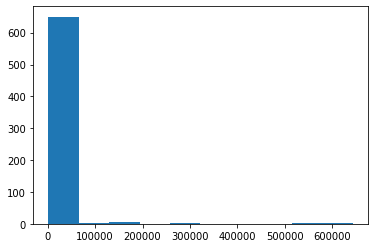

In [ ]:
plt.hist(df['NewCases'])

In [ ]:
# from scikit-learn's linear_model module. scikit_learn automatically adds a constant
lrm = LinearRegression()
lrm.fit(X, Y)
print('\nCoefficients: \n', lrm.coef_)
print('\nIntercept: \n', lrm.intercept_)


Coefficients: 
 [-2.86717363e+10 -6.15176096e-02 -1.06541156e+01  1.73770272e+01
 -2.81400615e+01  5.37161037e-01  3.92756273e-01 -5.39937370e+00
 -2.57404137e-02  3.50701672e-03 -1.39425108e+05  5.65953573e+05
 -1.23583285e+05 -9.69551732e+04 -1.15883868e+05 -7.20580558e+04
 -2.49220328e+05 -2.49226327e+05 -1.63231783e+05 -2.62842428e+04
 -2.47142700e+05  3.33014525e+06  6.63619524e+04 -8.72220392e+04
 -3.05924099e+04 -2.47364438e+05  2.54359516e+04 -4.91620934e+05
 -2.48837530e+05 -9.59836332e+04 -4.02996181e+04 -2.48981511e+05
  2.09833638e+03 -2.46656097e+05 -2.24981979e+04 -4.47212338e+05
 -1.36352783e+05  3.76090162e+04  1.30717847e+06 -2.49013894e+05
 -2.42789257e+04 -1.33119653e+05 -3.54803088e+04 -3.24292978e+03
  2.12352324e+04  4.00843895e+04 -7.80952474e+04 -4.58149481e+04
 -8.09381288e+03 -2.48970472e+05 -2.47922976e+05 -1.94030790e+04
 -1.16458920e+05 -2.76812266e+05 -9.18204256e+05 -1.27866765e+05
  3.43222663e+04  1.89017107e+04 -2.67294556e+05 -1.20700431e+05
 -2.6200

In [ ]:
#Assumtion 1. Linearity of model in its coefficients

In [ ]:
# Assumption 2. Error term = 0 on average
#The error term accounts for the variation in the targer variable that is not explained by the features. 
# Ideally, error=0. If, for example. error=-1, then the model systematically overpredicts the target variable. 
predictions = lrm.predict(X)
errors = Y - predictions

print("Mean of the errors in the model is: {}".format(np.mean(errors)))

Mean of the errors in the model is: -1.6381432702233483e-06


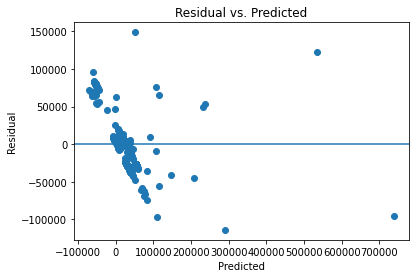

In [ ]:
#Assumption 3. Homoscedasticity, or when the error term is distributed evenly so error varience does not change over obsevations.
plt.scatter(predictions, errors)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.show()

In [ ]:
# The null hypothesis for both tests is that the errors are homoscedastic. Does this mean if both are are below .05 we reject the null 
# or something else?
bart_stats = bartlett(predictions, errors)
lev_stats = levene(predictions, errors)

print("Bartlett test statistic value is {0:3g} and p value is {1:.3g}".format(bart_stats[0], bart_stats[1]))
print("Levene test statistic value is {0:3g} and p value is {1:.3g}".format(lev_stats[0], lev_stats[1]))

Bartlett test statistic value is 159.341 and p value is 1.58e-36
Levene test statistic value is 2.07814 and p value is 0.15


In [ ]:
#Assumption 4. Low multicollinarity. 
#Which df do i check?
regression_df.corr()

,TotalCases,NewCases,TotalDeaths,NewDeaths,TotalRecovered,NewRecovered,ActiveCases,"Serious,Critical",TotalTests,Population,Afghanistan,Africa,Albania,Algeria,Andorra,Angola,Anguilla,Antigua and Barbuda,Argentina,Armenia,Aruba,Asia,Australia,Austria,Azerbaijan,Bahamas,Bahrain,Bangladesh,Barbados,Belarus,Belgium,Belize,Benin,Bermuda,Bhutan,Bolivia,Bosnia and Herzegovina,Botswana,Brazil,British Virgin Islands,...,St. Barth,St. Vincent Grenadines,Sudan,Suriname,Switzerland,Syria,Taiwan,Tajikistan,Tanzania,Thailand,Timor-Leste,Togo,Trinidad and Tobago,Tunisia,Turkey,Turks and Caicos,UAE,USA,Uganda,Ukraine,Uruguay,Uzbekistan,Vanuatu,Vatican City,Venezuela,Vietnam,Wallis and Futuna,Western Sahara,World,Yemen,Zambia,Zimbabwe,,Africa,All,Asia,Australia/Oceania,Europe,North America,South America
TotalCases,1.000000,0.832833,0.992771,4.862071e-01,-0.278912,7.631756e-01,0.934108,0.988008,0.166079,0.105468,-1.098439e-02,2.059001e-02,-1.125201e-02,-1.060894e-02,-1.159897e-02,-1.147553e-02,-1.169279e-02,-1.169066e-02,9.633875e-03,-9.806644e-03,-1.161617e-02,0.233974,-1.123569e-02,-8.590056e-03,-1.050901e-02,-1.157486e-02,-1.030184e-02,-4.615653e-03,-1.168873e-02,-9.850488e-03,-3.107779e-03,-1.161677e-02,-1.164591e-02,-1.168919e-02,-1.168678e-02,-9.334618e-03,-1.054425e-02,-1.155712e-02,8.413934e-02,-1.169167e-02,...,-1.169104e-02,-1.169156e-02,-1.145521e-02,-1.160595e-02,-7.486844e-03,-1.158509e-02,-1.168302e-02,-1.150251e-02,-1.168444e-02,-1.162915e-02,-1.169235e-02,-1.164962e-02,-1.159444e-02,-1.041981e-02,-4.978060e-03,-1.168103e-02,-9.251578e-03,0.169940,-1.143758e-02,-3.229355e-03,-1.162925e-02,-1.054246e-02,-1.169283e-02,-1.169240e-02,-1.010310e-02,-1.167213e-02,-1.169283e-02,-1.169268e-02,0.872326,-1.165866e-02,-1.141099e-02,-1.154859e-02,-1.656529e-02,-9.353177e-02,0.872326,-0.014958,-3.926124e-02,-0.023201,-0.006697,0.043468
NewCases,0.832833,1.000000,0.832929,6.356227e-01,-0.078176,8.669054e-01,0.858546,0.826870,0.077682,-0.001108,-2.176923e-04,-1.198143e-02,-2.176923e-04,-2.176923e-04,-2.176923e-04,-2.176923e-04,-2.176923e-04,-2.176923e-04,-1.598948e-02,-3.986708e-02,-2.176923e-04,0.092126,-2.176923e-04,-1.827339e-02,-4.012534e-02,-2.176923e-04,-2.176923e-04,-3.995681e-02,-2.176923e-04,-4.084871e-02,-3.317514e-02,-2.176923e-04,-2.176923e-04,-2.176923e-04,-2.176923e-04,-2.176923e-04,-4.039893e-02,-2.176923e-04,9.983217e-03,-2.176923e-04,...,-2.176923e-04,-2.176923e-04,-2.176923e-04,-2.176923e-04,-2.111048e-02,-2.176923e-04,-2.176923e-04,-2.176923e-04,-2.176923e-04,-2.176923e-04,-2.176923e-04,-2.176923e-04,-2.176923e-04,-2.686511e-02,-2.536585e-02,-2.176923e-04,-4.083612e-02,0.152906,-2.176923e-04,-2.341849e-02,-2.176923e-04,-2.176923e-04,-2.176923e-04,-2.176923e-04,-2.176923e-04,-2.176923e-04,-2.176923e-04,-2.176923e-04,0.765201,-2.176923e-04,-2.176923e-04,-2.176923e-04,-3.085623e-04,-1.711100e-02,0.765201,-0.082672,-7.389147e-04,-0.050592,0.039007,-0.014555
TotalDeaths,0.992771,0.832929,1.000000,4.902928e-01,-0.279364,7.665923e-01,0.936555,0.988271,0.133867,0.071791,-1.058991e-02,2.014641e-02,-1.126424e-02,-1.023462e-02,-1.162452e-02,-1.146047e-02,-1.167550e-02,-1.167324e-02,1.208732e-02,-1.051922e-02,-1.164627e-02,0.167145,-1.105895e-02,-1.055842e-02,-1.104604e-02,-1.157014e-02,-1.144982e-02,-7.489952e-03,-1.167074e-02,-1.097330e-02,-2.214284e-03,-1.162225e-02,-1.164627e-02,-1.166938e-02,-1.167550e-02,-5.675882e-03,-1.044852e-02,-1.165715e-02,1.003101e-01,-1.167482e-02,...,-1.167550e-02,-1.167550e-02,-1.091688e-02,-1.159801e-02,-9.437483e-03,-1.144733e-02,-1.167074e-02,-1.161795e-02,-1.166123e-02,-1.163471e-02,-1.167550e-02,-1.163471e-02,-1.160005e-02,-1.018704e-02,-3.997538e-03,-1.167142e-02,-1.131772e-02,0.157957,-1.157784e-02,-5.337811e-03,-1.163222e-02,-1.127195e-02,-1.167550e-02,-1.167550e-02,-1.110246e-02,-1.165171e-02,-1.167550e-02,-1.167482e-02,0.876418,-1.126424e-02,-1.143758e-02,-1.150125e-02,-1.654191e-02,-9.351897e-02,0.876418,-0.036250,-3.921339e-02,-0.028288,0.007022,0.064881
NewDeaths,0.486207,0.635623,0.490293,1.

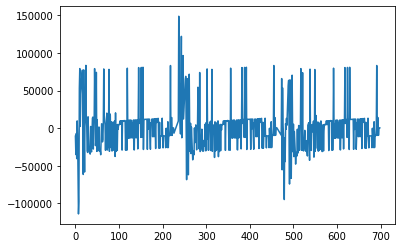

In [ ]:
#Assumption 5. Uncorrelated errors
plt.plot(errors)
plt.show()

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)


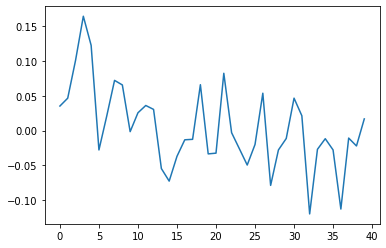

In [ ]:
from statsmodels.tsa.stattools import acf

acf_data = acf(errors)

plt.plot(acf_data[1:])
plt.show()
#This checks the correlation of a variable with itself. 

In [ ]:
#Assumption 6. Independence of features and errors / normality of error terms

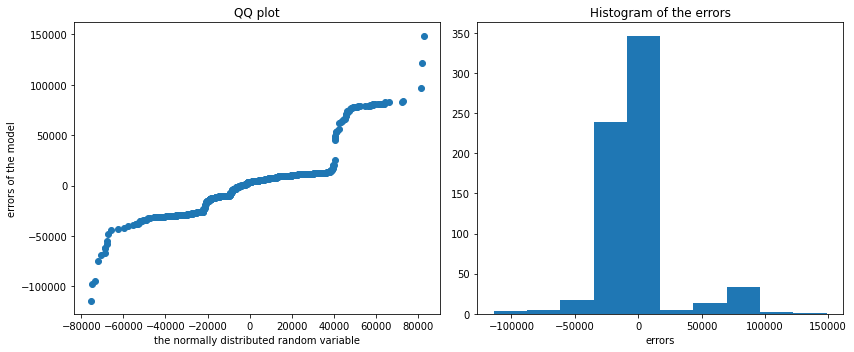

In [ ]:
rand_nums = np.random.normal(np.mean(errors), np.std(errors), len(errors))

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.scatter(np.sort(rand_nums), np.sort(errors)) # Sort the arrays
plt.xlabel("the normally distributed random variable")
plt.ylabel("errors of the model")
plt.title("QQ plot")

plt.subplot(1,2,2)
plt.hist(errors)
plt.xlabel("errors")
plt.title("Histogram of the errors")

plt.tight_layout()
plt.show()

In [ ]:
from scipy.stats import jarque_bera
from scipy.stats import normaltest

In [ ]:
jb_stats = jarque_bera(errors)
norm_stats = normaltest(errors)

print("Jarque-Bera test statistics is {0} and p value is {1}".format(jb_stats[0], jb_stats[1]))
print("Normality test statistics is {0} and p value is {1}".format(norm_stats[0], norm_stats[1]))

Jarque-Bera test statistics is 484.2775913699495 and p value is 0.0
Normality test statistics is 151.0815181333847 and p value is 1.5597865767260797e-33


In [ ]:
#From statsmodel, statsmodel does not automatically add a constant. 
X = sm.add_constant(X)
results = sm.OLS(Y, X).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               NewCases   R-squared:                       0.930
Model:                            OLS   Adj. R-squared:                  0.893
Method:                 Least Squares   F-statistic:                     25.24
Date:                Sat, 14 Nov 2020   Prob (F-statistic):          1.09e-164
Time:                        16:01:18   Log-Likelihood:                -7133.6
No. Observations:                 666   AIC:                         1.473e+04
Df Residuals:                     436   BIC:                         1.576e+04
Df Model:                         229                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                   1.835e+06   4.03e+05      4.554      0.000    1.04e+06    2.63e+06
TotalCases                 0.7482      0.261      2.870      0.004       0.236       1.260
TotalDeaths              -54.3007     12.125     -4.478      0.000     -78.132     -30.469
NewDeaths                 28.5793      2.685     10.644      0.000      23.302      33.856
TotalRecovered            -5.7953     75.089     -0.077      0.939    -153.377     141.786
NewRecovered               0.4884      0.054      9.123      0.000       0.383       0.594
ActiveCases                0.3485      0.273      1.279      0.202      -0.187       0.884
Serious,Critical          -7.7355      1.850     -4.180      0.000     -11.372      -4.099
TotalTests                -0.0226      0.007     -3.279      0.001      -0.036      -0.009
Population                 0.0031      0.001      4.140      0.000       0.002       0.005
Afghanistan             -1.04e+05    4.6e+04     -2.261      0.024   -1.94e+05   -1.36e+04
Africa                  1.002e+06    2.3e+05      4.346      0.000    5.49e+05    1.45e+06
Albania                -2.304e+05    5.6e+04     -4.113      0.000   -3.41e+05    -1.2e+05
Algeria                -8.056e+04   2.19e+04     -3.681      0.000   -1.24e+05   -3.75e+04
Andorra                  -2.3e+05   5.73e+04     -4.016      0.000   -3.43e+05   -1.17e+05
Angola                 -9.644e+04   2.02e+04     -4.779      0.000   -1.36e+05   -5.68e+04
Anguilla               -5.582e+05   1.07e+05     -5.197      0.000   -7.69e+05   -3.47e+05
Antigua and Barbuda    -5.584e+05   1.07e+05     -5.202      0.000   -7.69e+05   -3.47e+05
Argentina              -3.718e+05   7.21e+04     -5.153      0.000   -5.14e+05    -2.3e+05
Armenia                -5.678e+04   4.08e+04     -1.390      0.165   -1.37e+05    2.35e+04
Aruba                  -5.591e+05   1.08e+05     -5.198      0.000    -7.7e+05   -3.48e+05
Asia                    2.896e+06   1.59e+06      1.816      0.070   -2.38e+05    6.03e+06
Australia              -1.361e+04   5.28e+04     -0.258      0.797   -1.17e+05    9.02e+04
Austria                -2.807e+05   6.75e+04     -4.161      0.000   -4.13e+05   -1.48e+05
Azerbaijan             -6.169e+04   4.36e+04     -1.415      0.158   -1.47e+05     2.4e+04
Bahamas                -5.566e+05   1.07e+05     -5.207      0.000   -7.67e+05   -3.46e+05
Bahrain                -4.565e+04   4.31e+04     -1.060      0.290    -1.3e+05     3.9e+04
Bangladesh             -5.239e+05   1.05e+05     -4.971      0.000   -7.31e+05   -3.17e+05
Barbados               -5.581e+05   1.07e+05     -5.202      0.000   -7.69e+05   -3.47e+05
Belarus                -2.572e+05   6.25e+04     -4.115      0.000    -3.8e+05   -1.34e+05
Belgium                 4.449e+04   6.35e+04      0.700      0.484   -8.04e+04  

### KNeighborRegressor

###SVR

In [ ]:
from sklearn.svm import SVR

In [ ]:
svr = SVR()
svr.fit(X,Y)

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

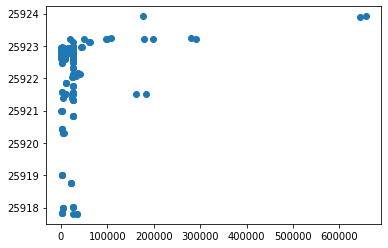

In [ ]:
plt.scatter(Y, svr.predict(X))

In [ ]:
svr.score(X, Y)

-5.130547636067462e-06

In [ ]:
cross_val_score(svr, X, Y, cv=5)

array([-0.03341106, -0.00924612, -0.21949421, -0.00146698, -0.00756712])

In [ ]:
knnr = KNeighborsRegressor(n_neighbors=10)
knnr.fit(X,Y)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=10, p=2,
                    weights='uniform')

In [ ]:
#We can use this model to predict 
T = np.arange(0, 50)[:, np.newaxis]

# Generating predictions for each of the loudness values.
Y_ = knnr.predict(T)

# Plotting the training data and the prediction line for the newly-generated loudness values.
plt.scatter(X, Y, c='k', label='data')
plt.plot(T, Y_, c='g', label='prediction')
plt.legend()
plt.title('K=10, Unweighted')
plt.show()

ValueError: ignored

In [ ]:
# Run the same model, this time with weights.
knn_w = neighbors.KNeighborsRegressor(n_neighbors=10, weights='distance')
X = pd.DataFrame(music.loudness)
Y = music.bpm
knn_w.fit(X, Y)

# Set up our prediction line.
T = np.arange(0, 50, 0.1)[:, np.newaxis]

Y_ = knn_w.predict(T)

plt.scatter(X, Y, c='k', label='data')
plt.plot(T, Y_, c='g', label='prediction')
plt.legend()
plt.title('K=10, Weighted')
plt.show()

#Problem solving space

In [ ]:
tdf = pd.DataFrame(df['NewCases'])

NewCases    26980.818182
dtype: float64

In [ ]:
df.head()

,#,"Country,Other",TotalCases,NewCases,TotalDeaths,NewDeaths,TotalRecovered,NewRecovered,ActiveCases,"Serious,Critical",Tot Cases/1M pop,Deaths/1M pop,TotalTests,Tests/\n1M pop\n,Population,Continent,1 Caseevery X ppl,1 Deathevery X ppl,1 Testevery X ppl
0,,North America,13018544.0,150518.0,373127.0,1655.0000,0.0,43507.0,4382780.0,35859.0,,,0.0,,0.0,North America,\n,,
1,,Asia,14903843.0,99095.0,263273.0,1626.0000,0.0,83661.0,1345359.0,24251.0,,,0.0,,0.0,Asia,\n,,
2,,South America,10216433.0,6986.0,307163.0,3614.9375,0.0,1484.0,676937.0,17449.0,,,0.0,,0.0,South America,\n,,
3,,Europe,13474618.0,270059.0,315504.0,4534.0000,0.0,94621.0,8197070.0,28982.0,,,0.0,,0.0,Europe,\n,,
4,,Africa,1960374.0,14005.0,46889.0,3614.9375,0.0,9100.0,263107.0,2540.0,,,0.0,,0.0,Africa,\n,,


In [ ]:
clean_df['NewCases'].dtype()

TypeError: ignored

In [ ]:
encoded_df.head(15)

,"Country,Other",Continent,TotalCases,NewCases,TotalDeaths,NewDeaths,TotalRecovered,NewRecovered,ActiveCases,"Serious,Critical",TotalTests,Population,,Africa,All,Asia,Australia/Oceania,Europe,North America,South America
0,North America,North America,12916827.0,55401.000000,372439.0,3536.666667,0.0,14263.000000,4310995.0,35615.0,0.0,0.000000e+00,0,0,0,0,0,0,1,0
1,Asia,Asia,14892500.0,87752.000000,263148.0,1501.000000,0.0,72572.000000,1345230.0,24251.0,0.0,0.000000e+00,0,0,0,1,0,0,0,0
2,South America,South America,10215272.0,5825.000000,307132.0,3536.666667,0.0,1484.000000,675807.0,17465.0,0.0,0.000000e+00,0,0,0,0,0,0,0,1
3,Europe,Europe,13445586.0,241027.000000,314494.0,3524.000000,0.0,92312.000000,8171357.0,28979.0,0.0,0.000000e+00,0,0,0,0,0,1,0,0
4,Africa,Africa,1955710.0,9341.000000,46742.0,3536.666667,0.0,6247.000000,261443.0,2545.0,0.0,0.000000e+00,0,1,0,0,0,0,0,0
5,Oceania,Australia/Oceania,41865.0,26595.362162,993.0,3536.666667,0.0,23787.362903,7993.0,24.0,0.0,0.000000e+00,0,0,0,0,1,0,0,0
7,World,All,53468481.0,399353.000000,1304963.0,6335.000000,0.0,186886.000000,14772872.0,108883.0,0.0,0.000000e+00,0,0,1,0,0,0,0,0
8,USA,North America,10918789.0,44853.000000,248835.0,3536.666667,1.0,6062.000000,3935772.0,31789.0,163749543.0,3.317169e+08,0,0,0,0,0,0,1,0
9,India,Asia,8761499.0,33599.000000,129100.0,3536.666667,2.0,38310.000000,480744.0,8944.0,123101739.0,1.384975e+09,0,0,0,1,0,0,0,0
10,Brazil,South America,5787766.0,4119.000000,164514.0,3536.666667,3.0,23787.362903,366485.0,8318.0,21900000.0,2.131146e+08,0,0,0,0,0,0,0,1


In [ ]:
clean_df.head(15)

,"Country,Other",Continent,TotalCases,NewCases,TotalDeaths,NewDeaths,TotalRecovered,NewRecovered,ActiveCases,"Serious,Critical",TotalTests,Population
0,North America,North America,12916827.0,55401.000000,372439.0,3536.666667,0.0,14263.000000,4310995.0,35615.0,0.0,0.000000e+00
1,Asia,Asia,14892500.0,87752.000000,263148.0,1501.000000,0.0,72572.000000,1345230.0,24251.0,0.0,0.000000e+00
2,South America,South America,10215272.0,5825.000000,307132.0,3536.666667,0.0,1484.000000,675807.0,17465.0,0.0,0.000000e+00
3,Europe,Europe,13445586.0,241027.000000,314494.0,3524.000000,0.0,92312.000000,8171357.0,28979.0,0.0,0.000000e+00
4,Africa,Africa,1955710.0,9341.000000,46742.0,3536.666667,0.0,6247.000000,261443.0,2545.0,0.0,0.000000e+00
5,Oceania,Australia/Oceania,41865.0,26595.362162,993.0,3536.666667,0.0,23787.362903,7993.0,24.0,0.0,0.000000e+00
7,World,All,53468481.0,399353.000000,1304963.0,6335.000000,0.0,186886.000000,14772872.0,108883.0,0.0,0.000000e+00
8,USA,North America,10918789.0,44853.000000,248835.0,3536.666667,1.0,6062.000000,3935772.0,31789.0,163749543.0,3.317169e+08
9,India,Asia,8761499.0,33599.000000,129100.0,3536.666667,2.0,38310.000000,480744.0,8944.0,123101739.0,1.384975e+09
10,Brazil,South America,5787766.0,4119.000000,164514.0,3536.666667,3.0,23787.362903,366485.0,8318.0,21900000.0,2.131146e+08


pandas.core.series.Series

In [ ]:
#TotalRecovered
TR_df = pd.DataFrame(df['TotalRecovered'])
TR_df = TR_df[TR_df['TotalRecovered'] != 'N/A']
TR_df['TotalRecovered'] = TR_df['TotalRecovered'].astype(str).apply(lambda x: f'{x}.0')
TR_df['TotalRecovered'] = TR_df['TotalRecovered'].str.replace(',', '')
TR_df['TotalRecovered'] = TR_df['TotalRecovered'].str.replace(' ', '')
TR_df['TotalRecovered'] = TR_df['TotalRecovered'].astype(float)
x = round(TR_df['TotalRecovered'].mean())
print(x)
df['TotalRecovered'] = df[df['TotalRecovered'] != 'N/A']
df['TotalRecovered'] = df['TotalRecovered'].fillna(x)
df['TotalRecovered'] = df['TotalRecovered'].astype(str).apply(lambda x: f'{x}.0')
df['TotalRecovered'] = df['TotalRecovered'].str.replace(',', '')
df['TotalRecovered'] = df['TotalRecovered'].str.replace(' ', '')

df['TotalRecovered'] = df['TotalRecovered'].astype(float)

In [ ]:
TR_df = df.copy()
#TR_df['TotalRecovered'] = TR_df[TR_df['TotalRecovered'] != 'N/A']
print()
#TR_df['TotalRecovered'] = TR_df[TR_df['TotalRecovered'] != 'nan']

TR_df['TotalRecovered'] = TR_df['TotalRecovered'].astype(str).apply(lambda x: f'{x}.0')

TR_df['TotalRecovered'] = TR_df['TotalRecovered'].str.replace(',', '')

TR_df['TotalRecovered'] = TR_df['TotalRecovered'].str.replace(' ', '')

TR_df['TotalRecovered'] = TR_df['TotalRecovered'].astype(float)

In [ ]:
TR_df = df.copy()
TR_df['TotalRecovered'].isna().sum()
print(len(test_df[test_df['TotalRecovered'] == 'N/A']))
print(test_df['TotalRecovered'].isna().sum())
print('---')
TR_df = df.copy()
TR_df['TotalRecovered'] = TR_df[TR_df['TotalRecovered'] != 'N/A']
TR_df['TotalRecovered'].isna().sum()
print(len(test_df[test_df['TotalRecovered'] == 'N/A']))
print(test_df['TotalRecovered'].isna().sum())
print('---')


print(len(test_df[test_df['TotalRecovered'] == 'N/A']))
print(test_df['TotalRecovered'].isna().sum())
print('---')
TR_df = df.copy()
TR_df['TotalRecovered'] = TR_df[TR_df['TotalRecovered'] != 'N/A']
TR_df['TotalRecovered'] = TR_df[TR_df['TotalRecovered'] != 'nan']
TR_df['TotalRecovered'] = TR_df['TotalRecovered'].astype(str).apply(lambda x: f'{x}.0')
TR_df['TotalRecovered'] = TR_df['TotalRecovered'].str.replace(',', '')
TR_df['TotalRecovered'] = TR_df['TotalRecovered'].str.replace(' ', '')
TR_df['TotalRecovered'] = TR_df['TotalRecovered'].astype(float)
TR_df['TotalRecovered'].mean()


In [ ]:
len(df[df['TotalRecovered'] == 'N/A'])

In [ ]:
test_df[test_df['TotalRecovered'] == 'N/A']

In [ ]:
test_df.head(10)

In [ ]:
test_df = df.copy()

def process_numeric(col_name):
  test_df[col_name] = test_df[col_name].apply(lambda x: f'{x}.0')
  for i in test_df:
    try:
      test_df.iloc[i] = test_df[i].str.replace(',', '').astype(float)
    except ValueError:
      test_df[i] = test_df[i].map(lambda x: x.rstrip(' .0'))
      test_df[i] = test_df[i].str.replace(',', '').astype(float)

process_numeric('TotalDeaths')

In [ ]:
test_df = df.copy()
test_df['TotalDeaths'] = test_df['TotalDeaths'].apply(lambda x:f'str{x}')
for i in column:
try:
  test_df['TotalDeaths'] = test_df['TotalDeaths'].str.replace(',', '').astype(float)
except ValueError: 
  test_df['TotalDeaths'] = test_df['TotalDeaths'].map(lambda x: x.lstrip('str'))
  test_df['TotalDeaths'] = test_df['TotalDeaths'].str.replace(',', '').astype(float)

In [ ]:
test_df = df.copy()

In [ ]:
test_df.head(10)

In [ ]:
test_df[test_df.TotalRecovered == 'N/A']

In [ ]:
test_df = df.copy()
TR_df = pd.DataFrame(test_df['TotalRecovered'])
TR_df = TR_df.dropna()
TR_df = TR_df[TR_df['TotalRecovered'] != '']
TR_df = NR_df[TR_df['TotalRecovered'] != 'N/A']
#TR_df['TotalRecovered'] = TR_df['TotalRecovered'].str.replace(',','').astype(float)
#TR_df['TotalRecovered'].mean()
TR_df[TR_df['TotalRecovered']]

In [ ]:
#test_df['TotalCases'] = test_df['TotalCases'].str.replace('', '').astype(float)
#test_df[test_df['TotalCases'] < 1000]

#test_df['TotalDeaths'] = test_df['TotalDeaths'].map(lambda x: x.lstrip('str').rstrip('.0'))
test_df['TotalRecovered'] = test_df[test_df['TotalRecovered'] != 'N/A']
test_df['TotalRecovered'] = test_df['TotalRecovered'].apply(lambda x:f'{x}.0')
test_df['TotalRecovered'] = test_df['TotalRecovered'].str.replace(',', '').astype(float)

#try:
  #test_df['TotalDeaths'] = test_df['TotalDeaths'].str.replace(',', '').astype(float)
#except: 
  #test_df['TotalDeaths'] = test_df['TotalDeaths'].map(lambda x: x.rstrip(' .0')).astype(float)
  #test_df['TotalDeaths'] = test_df['TotalDeaths'].str.replace(',', '').astype(float)


In [ ]:
test_df.head(15)

In [ ]:
df[df.TotalDeaths == 248585 ]

In [ ]:
df.tail(15)

In [ ]:
df[df['Country,Other'] == 'USA']

In [ ]:
country_list = df['Country,Other'].unique()

In [ ]:
len(country_list)

In [ ]:
country_list = df['Country,Other'].unique()
for i in country_list:
  if len(df[df['Country,Other'] == i]) == 3:
    pass
  else:
    print(f'{i}')
